# Prodiction on Trending YouTube Video Project

YouTube has a list of the top trending videos that measures user's’ interaction, such as the number of views/likes/comments/shares. 
In this project, we want to explore among the trending videos, what factor(s) can predict the trending videos get the likes/dislikes/comments.


This project will use different Machine Learning Models to conduct prediction on YouTube videos' likes, among the feature variables:

0. Load in a dataset from [Kaggle](https://www.kaggle.com/). 
0. Conduct data preprocessing and data visualization
0. Create a Delta Table
0. Keep track of models’ performance by conducting ‘RMSE’ and ‘R2’ evaluation with MLflow. 
0. Conduct feature engineering to find the most importance features. 
0. Conlude with findings and future adjustment.

### Data Loading and Exploratory Data Analysis
######  First, load the csv file from local drive and store it in the Spark dataframe. 
######  Also do a quick check on what each data types are for the given data.

In [0]:
file_path = "dbfs:/FileStore/shared_uploads/ngaukahang@gmail.com/USvideos.csv"
df = spark.read.csv(file_path, header="true", inferSchema="true", multiLine="true", escape='"')
display(df.dtypes)

_1,_2
video_id,string
trending_date,string
title,string
channel_title,string
category_id,int
publish_time,timestamp
tags,string
views,int
likes,int
dislikes,int


In [0]:
print(df.toPandas().shape)

(40949, 16)

### Data Preprocessing
###### As we can see from the data types of variable 'publish_time', it is 'timestamp' type so that we can use function from pyspark.sql to extract the Value of year, quarter, month, dayofweek, hour from it.

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.functions import date_format

# extracting the information of year, month, quarter, and dayofweek from the column "publish_time"
df_date = df.withColumn("publish_year", year("publish_time").alias("year"))
df_date1 = df_date.withColumn("publish_month", month("publish_time").alias("month"))
df_date2 = df_date1.withColumn("publish_quarter", quarter("publish_time").alias("quarter"))
df_date3 = df_date2.withColumn("publish_dayofweek", dayofweek("publish_time").alias("dayofweek"))
df_date4 = df_date3.withColumn('publish_hour', date_format('publish_time', 'HH'))

###### Take a look on the dataframe with new columns

In [0]:
display(df_date4.select('publish_time','publish_hour', 'publish_dayofweek', 'publish_month', 'publish_quarter', 'publish_year').limit(5))

publish_time,publish_hour,publish_dayofweek,publish_month,publish_quarter,publish_year
2017-11-13T17:13:01.000+0000,17,2,11,4,2017
2017-11-13T07:30:00.000+0000,07,2,11,4,2017
2017-11-12T19:05:24.000+0000,19,1,11,4,2017
2017-11-13T11:00:04.000+0000,11,2,11,4,2017
2017-11-12T18:01:41.000+0000,18,1,11,4,2017


###### Converting the spark dataframe into pandas dataframe so that we can do some exploratory data analysis

In [0]:
import pandas as pd 

df_pd = df_date4.toPandas()

###### Combining 'tags', 'title', and 'channel_tile' columns into one 'text' column.
###### To find if there are any null values from each columns

In [0]:
df_pd['text'] = df_pd['title']+df_pd['channel_title']+df_pd['tags']
df_pd.isnull().sum()

Out[4]: video_id 0
trending_date 0
title 0
channel_title 0
category_id 0
publish_time 0
tags 0
views 0
likes 0
dislikes 0
comment_count 0
thumbnail_link 0
comments_disabled 0
ratings_disabled 0
video_error_or_removed 0
description\r 570
publish_year 0
publish_month 0
publish_quarter 0
publish_dayofweek 0
publish_hour 0
text 0
dtype: int64

### NLP Analysis
###### Importing nltk package to do some Natural Language Processing on the data set

In [0]:
import nltk
from nltk.stem import *
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
from functools import reduce
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Unzipping tokenizers/punkt.zip.
/databricks/python/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
 from pandas import Panel

###### To get rid of some of the redundant words by applying NLP analysis in 'Stopwords' and 'Lemmatizer' functions.

In [0]:
from nltk.corpus import stopwords
nltk.download('wordnet') 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def process(line):
    return([wordnet_lemmatizer.lemmatize(t) for t in tokenizer.tokenize(line) if t not in stop_words])
    

tokenizer = RegexpTokenizer(r'\w+')
df_pd['tokens']=df_pd['text'].str.lower().apply(process)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Unzipping corpora/stopwords.zip.

###### Find the most frequent words from the tokenized column 'token'. 
###### And store the frequent words in column 'most_common'.

In [0]:
def most_frequent(List): 
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num
  
df_pd['most_common'] = df_pd['tokens'].apply(most_frequent)

df_pd.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description\r,publish_year,publish_month,publish_quarter,publish_dayofweek,publish_hour,text,tokens,most_common
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,2017,11,4,2,17,WE WANT TO TALK ABOUT OUR MARRIAGECaseyNeistat...,"[want, talk, marriagecaseyneistatshantell, mar...",want
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00,"""last week tonight trump presidency""|""last wee...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",2017,11,4,2,07,The Trump Presidency: Last Week Tonight with J...,"[trump, presidency, last, week, tonight, john,...",trump
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24,"""racist superman""|""rudy""|""mancuso""|""king""|""bac...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,2017,11,4,1,19,"Racist Superman | Rudy Mancuso, King Bach & Le...","[racist, superman, rudy, mancuso, king, bach, ...",mancuso
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04,"""rhett and link""|""gmm""|""good mythical morning""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,2017,11,4,2,11,Nickelback Lyrics: Real or Fake?Good Mythical ...,"[nickelback, lyric, real, fake, good, mythical...",nickelback
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41,"""ryan""|""higa""|""higatv""|""nigahiga""|""i dare you""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,2017,11,4,1,18,"I Dare You: GOING BALD!?nigahiga""ryan""|""higa""|...","[dare, going, bald, nigahiga, ryan, higa, higa...",dare


###### Do a counting in the column 'most_common' and find the top 10 most frequent words. Store them in the dataframe 'rslt' below.

In [0]:
from collections import Counter
one = df_pd['most_common'].to_list()

rslt = pd.DataFrame(Counter(one).most_common(10),
                    columns=['Word', 'Frequency']).set_index('Word')
rslt

,Frequency
Word,
makeup,725
late,340
cat,316
trailer,285
news,234
show,221
star,219
movie,207
react,200


###### Creating a column 'popular_word', to store True or False for each row, if its word in column 'most_common' is also in the list of top 10 most frequent words or not.

In [0]:
def popular(List_1):
  first = rslt.index.to_list() 
  if List_1 in first:
    return True
  else:
    return False 

df_pd['popular_word'] = df_pd['most_common'].apply(lambda d: popular(d))

print(df_pd['popular_word'].value_counts())

False 38009
True 2940
Name: popular_word, dtype: int64

In [0]:
df_pd.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description\r,publish_year,publish_month,publish_quarter,publish_dayofweek,publish_hour,text,tokens,most_common,popular_word
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,2017,11,4,2,17,WE WANT TO TALK ABOUT OUR MARRIAGECaseyNeistat...,"[want, talk, marriagecaseyneistatshantell, mar...",want,False
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00,"""last week tonight trump presidency""|""last wee...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",2017,11,4,2,07,The Trump Presidency: Last Week Tonight with J...,"[trump, presidency, last, week, tonight, john,...",trump,False
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24,"""racist superman""|""rudy""|""mancuso""|""king""|""bac...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,2017,11,4,1,19,"Racist Superman | Rudy Mancuso, King Bach & Le...","[racist, superman, rudy, mancuso, king, bach, ...",mancuso,False
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04,"""rhett and link""|""gmm""|""good mythical morning""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,2017,11,4,2,11,Nickelback Lyrics: Real or Fake?Good Mythical ...,"[nickelback, lyric, real, fake, good, mythical...",nickelback,False
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41,"""ryan""|""higa""|""higatv""|""nigahiga""|""i dare you""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,2017,11,4,1,18,"I Dare You: GOING BALD!?nigahiga""ryan""|""higa""|...","[dare, going, bald, nigahiga, ryan, higa, higa...",dare,False


###### Convert all boolean type column to integer type column, so that it will only show (0 / 1)

In [0]:
df_pd["popular_word"] = df_pd["popular_word"].astype(int)
df_pd["comments_disabled"] = df_pd["comments_disabled"].astype(int)
df_pd["ratings_disabled"] = df_pd["ratings_disabled"].astype(int)
df_pd["video_error_or_removed"] = df_pd["video_error_or_removed"].astype(int)
df_pd["publish_hour"] = df_pd["publish_hour"].astype(int)

### Data Visualization 
###### Correlation between dislike, views, comment_counts to likes.

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt 

df_pd.corr()

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_year,publish_month,publish_quarter,publish_dayofweek,publish_hour,popular_word
category_id,1.000000,-0.168231,-0.173921,-0.033547,-0.076307,0.048949,-0.013506,-0.030011,0.020314,-0.013159,-0.016447,-0.037944,0.077981,0.023975
views,-0.168231,1.000000,0.849177,0.472213,0.617621,0.002677,0.015355,-0.002256,0.075538,-0.026924,-0.021629,0.013193,-0.064916,-0.025832
likes,-0.173921,0.849177,1.000000,0.447186,0.803057,-0.028918,-0.020888,-0.002641,0.064893,-0.016893,-0.014356,0.021694,-0.045296,-0.032817
dislikes,-0.033547,0.472213,0.447186,1.000000,0.700184,-0.004431,-0.008230,-0.001853,0.016897,-0.000153,0.002098,-0.000366,-0.009750,-0.016926
comment_count,-0.076307,0.617621,0.803057,0.700184,1.000000,-0.028277,-0.013819,-0.003725,0.041378,-0.013080,-0.011353,0.007829,-0.017421,-0.007143
comments_disabled,0.048949,0.002677,-0.028918,-0.004431,-0.028277,1.000000,0.319230,-0.002970,-0.009302,0.014006,0.012675,-0.014678,-0.012056,-0.012612
ratings_disabled,-0.013506,0.015355,-0.020888,-0.008230,-0.013819,0.319230,1.000000,-0.001526,-0.005536,-0.010076,-0.010034,-0.023229,0.010757,-0.017904
video_error_or_removed,-0.030011,-0.002256,-0.002641,-0.001853,-0.003725,-0.002970,-0.001526,1.000000,0.006079,-0.000687,0.002790,0.023049,0.002465,-0.006593
publish_year,0.020314,0.075538,0.064893,0.016897,0.041378,-0.009302,-0.005536,0.006079,1.000000,-0.696421,-0.689407,-0.019039,-0.002190,0.031927
publish_month,-0.013159,-0.026924,-0.016893,-0.000153,-0.013080,0.014006,-0.010076,-0.000687,-0.696421,1.000000,0.982738,0.030995,0.009578,-0.022227


###### Correlation between all features to likes.

In [0]:
import six
for i in df_base4.columns:
    if not( isinstance(df_base4.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to likes for ", i, df_base4.stat.corr('likes',i))

Correlation to likes for publish_year 0.06489273235963669
Correlation to likes for publish_month -0.01689284679274735
Correlation to likes for publish_quarter -0.014355534245320663
Correlation to likes for publish_dayofweek 0.021693932429804
Correlation to likes for publish_hour -0.04529574054352491
Correlation to likes for category_id -0.17392077195292174
Correlation to likes for views 0.8491765212088963
Correlation to likes for likes 1.0
Correlation to likes for dislikes 0.4471864632166012
Correlation to likes for comment_count 0.8030568578359273
Correlation to likes for comments_disabled -0.028917523269866255
Correlation to likes for ratings_disabled -0.020888209357161805
Correlation to likes for video_error_or_removed -0.0026407555837714893
Correlation to likes for popular_word -0.03281748682245744

###### Ploting to find the relationship between dislike, views, comment_counts and likes.

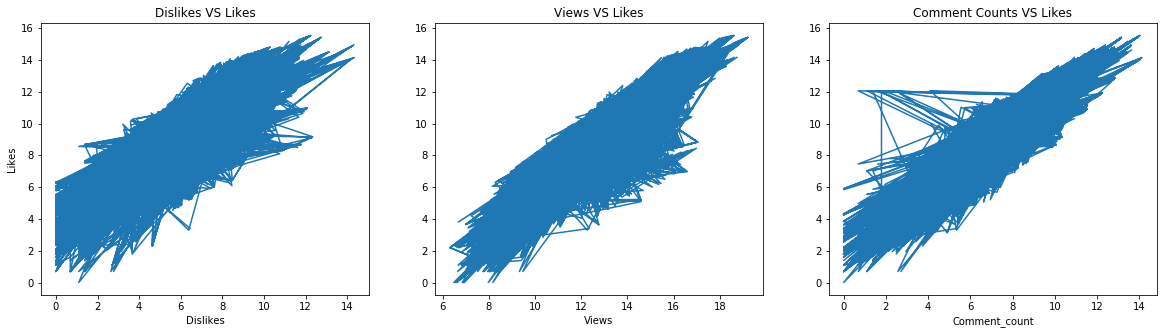

In [0]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(y2, y1)
plt.title('Dislikes VS Likes')
plt.xlabel('Dislikes')
plt.ylabel('Likes')

plt.subplot(132)
plt.plot(x1, y1)
plt.title('Views VS Likes')
plt.xlabel('Views')

plt.subplot(133)
plt.plot(y3, y1)
plt.title('Comment Counts VS Likes')
plt.xlabel('Comment_count')

plt.show()

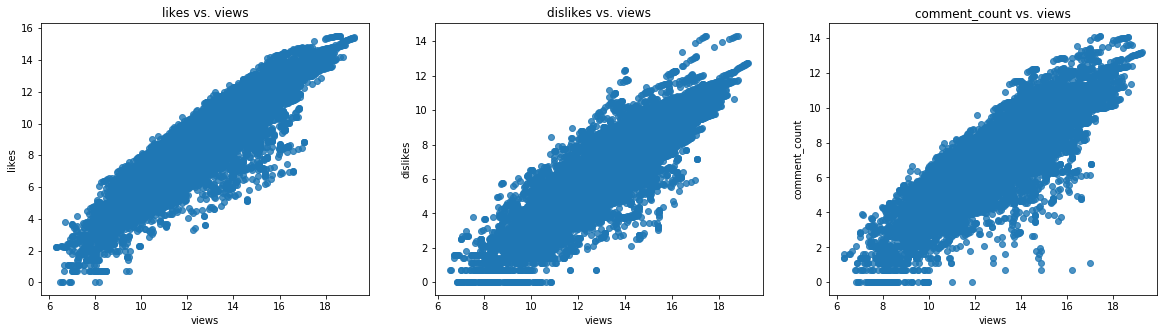

In [0]:
import numpy as np

x1=np.log(df_pd["views"])
y1=np.log(df_pd["likes"])
y2=np.log(df_pd["dislikes"])
y3=np.log(df_pd["comment_count"])

fig, axes = plt.subplots(1, 3, figsize = (20, 5))
sns.regplot(x=x1,y=y1,fit_reg=False, ax = axes[0]);
axes[0].set_title('likes vs. views');

sns.regplot(x=x1,y=y2,fit_reg=False, ax = axes[1]);
axes[1].set_title('dislikes vs. views');

sns.regplot(x=x1,y=y3,fit_reg=False, ax = axes[2]);
axes[2].set_title('comment_count vs. views');

In [0]:
ratio = pd.DataFrame(list(zip(df_pd['ratings_disabled'].value_counts(), df_pd['comments_disabled'].value_counts(), df_pd['video_error_or_removed'].value_counts())), columns=["ratings_disabled", "comments_disabled", "video_error_or_removed"])
ratio

,ratings_disabled,comments_disabled,video_error_or_removed
0,40780,40316,40926
1,169,633,23


###### Distribution between publish_dayofweek, publish_month, publish_quarter, and publish_year.

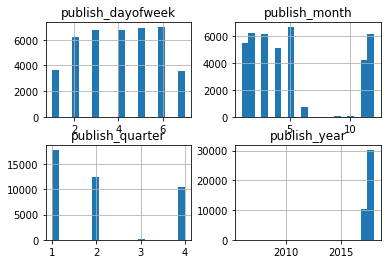

In [0]:
# conducting some visulization on the distrubtion of 'year', 'month', 'quarter', and 'dayofweek'
plt.clf()
df_pd.hist(column=["publish_year","publish_month","publish_quarter","publish_dayofweek"], bins=20)
plt.show()

###### Distribution of publish_hour according to 'likes'.

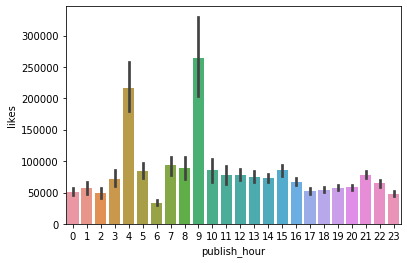

In [0]:
sns.barplot(x="publish_hour", y="likes", data=df_pd)

###### Views vs Likes among dayofweek distributed on quarters

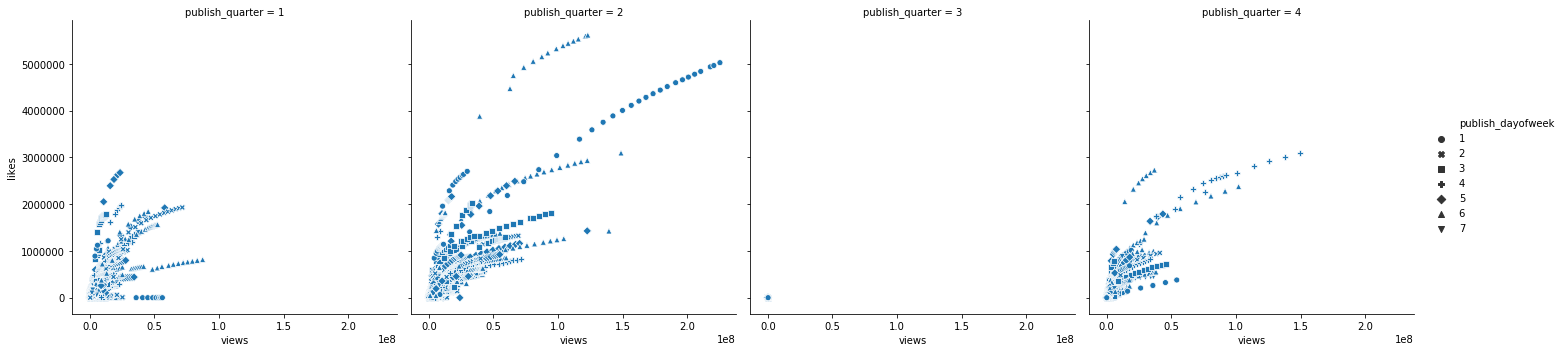

In [0]:
sns.relplot(
    data=df_pd, x="views", y="likes",
    col="publish_quarter", style="publish_dayofweek",
    kind="scatter"
)

###### Converting back to spark dataframe

In [0]:
df_base_new = sqlContext.createDataFrame(df_pd)

###### Select the finalized columns to keep and display the finalized dataframe

In [0]:
from pyspark.sql.types import *

columns_keep = [
 'publish_year',
 'publish_month',
 'publish_quarter',
 'publish_dayofweek',
 'publish_hour',
 'category_id',
 'views',
 'likes',
 'dislikes',
 'comment_count',
 'comments_disabled',
 'ratings_disabled',
 'video_error_or_removed',
 'popular_word'
]

#df_date3.cache().count()
df_base = df_base_new.select(columns_keep)

display(df_base.limit(5))

publish_year,publish_month,publish_quarter,publish_dayofweek,publish_hour,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,popular_word
2017,11,4,2,17,22,748374,57527,2966,15954,0,0,0,0
2017,11,4,2,7,24,2418783,97185,6146,12703,0,0,0,0
2017,11,4,1,19,23,3191434,146033,5339,8181,0,0,0,0
2017,11,4,2,11,24,343168,10172,666,2146,0,0,0,0
2017,11,4,1,18,24,2095731,132235,1989,17518,0,0,0,0


###### Do the last converting of datatype and ready to go

In [0]:
df_base1 = df_base.withColumn("comments_disabled", col("comments_disabled").cast("int"))
df_base2 = df_base1.withColumn("ratings_disabled", col("ratings_disabled").cast("int"))
df_base3 = df_base2.withColumn("video_error_or_removed", col("video_error_or_removed").cast("int"))
df_base5 = df_base3.withColumn("publish_hour", col("publish_hour").cast("int"))
df_base4 = df_base5.withColumn("popular_word", col("popular_word").cast("int"))

df_base4.dtypes

Out[59]: [('publish_year', 'int'),
 ('publish_month', 'int'),
 ('publish_quarter', 'int'),
 ('publish_dayofweek', 'int'),
 ('publish_hour', 'int'),
 ('category_id', 'int'),
 ('views', 'int'),
 ('likes', 'int'),
 ('dislikes', 'int'),
 ('comment_count', 'int'),
 ('comments_disabled', 'int'),
 ('ratings_disabled', 'int'),
 ('video_error_or_removed', 'int'),
 ('popular_word', 'int')]

In [0]:
house_df = df_base4
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
publish_year,40949,2017.714669466898,0.6040750477868407,2006,2018
publish_month,40949,5.287430706488559,3.915822472862134,1,12
publish_quarter,40949,2.075508559427581,1.205759836206378,1,4
publish_dayofweek,40949,4.037998485921512,1.7943563253568138,1,7
publish_hour,40949,13.766685389142593,6.424995970417838,0,23
category_id,40949,19.97242911914821,7.56832682828046,1,43
views,40949,2360784.6382573447,7394113.759703941,549,225211923
likes,40949,74266.7024347359,228885.33820949928,0,5613827
dislikes,40949,3711.400888910596,29029.70594500179,0,1674420


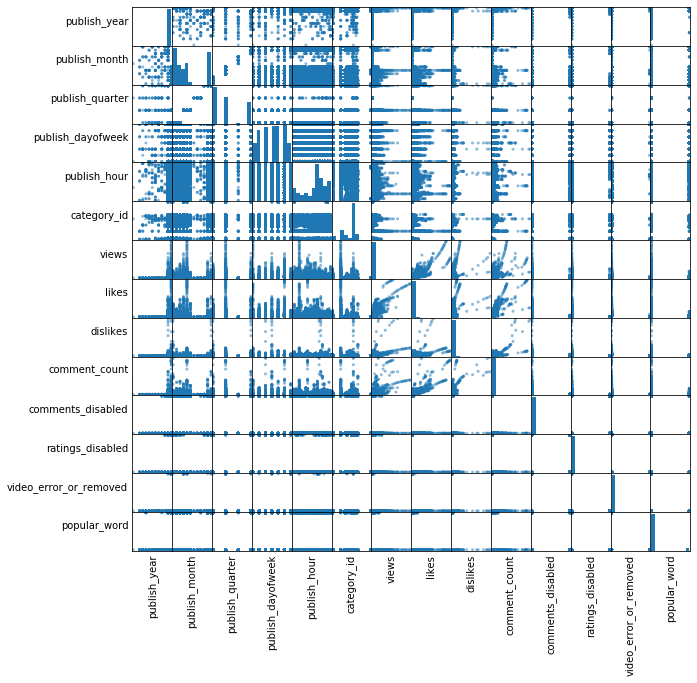

In [0]:
from pandas.plotting import scatter_matrix

numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

###### Store all the feature columns besides 'likes', to 'feature_list'. Then apply VectorAssembler to convert all features to OutPutColumn.

In [0]:
from pyspark.ml.feature import VectorAssembler

feature_list = []
for col in df_base4.columns:
    if col == 'likes':
        continue
    else:
        feature_list.append(col)
        
vecAssembler = VectorAssembler(inputCols=feature_list, outputCol="features")

###### Randomly split the dataset into train and test, with 0.8 and 0.2.

In [0]:
(trainDF, testDF) = df_base4.randomSplit([.8, .2], seed=345)

###### Storing the train-test data in delta table

In [0]:
trainDeltaPath = "dbfs:/FileStore/shared_uploads/ngaukahang@gmail.com/machine-learning-p/train.delta"
testDeltaPath = "dbfs:/FileStore/shared_uploads/ngaukahang@gmail.com/machine-learning-p/test.delta"

dbutils.fs.rm(trainDeltaPath, True)
dbutils.fs.rm(testDeltaPath, True)

(trainDF
  .write
  .mode("overwrite")
  .format("delta")
  .save(trainDeltaPath)
)

(testDF
  .write
  .mode("overwrite")
  .format("delta")
  .save(testDeltaPath)
)

In [0]:
data_version = 0
trainDelta = spark.read.format("delta").option("versionAsOf", data_version).load(trainDeltaPath)  
testDelta = spark.read.format("delta").option("versionAsOf", data_version).load(testDeltaPath)

### Linear Regression Model
###### Building up the Linear Regression Model with PySpark.mlFlow.log_param to fit the model

In [0]:
import mlflow
import mlflow.spark
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import RFormula

mlflow.set_experiment(f"/Users/ngaukahang@gmail.com/tr-mlflow-lab")

# The feature columns will the variable in feature_list, and the label column will be 'likes'
mlflow.log_param("label", "likes-all-features")
mlflow.log_param("data_version", data_version)
mlflow.log_param("data_path", trainDeltaPath)    
  
# set the linear regression model with maxIter=10, regParam=0.3, elasticNetParam=0.8. 
lr = LinearRegression(labelCol="likes", featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# putting all the features in pipeline stages
stages = [vecAssembler, lr]
pipeline_lr = Pipeline(stages=stages)

# used the pipeline to fit the lr model
pipelineModel_lr = pipeline_lr.fit(trainDelta)
mlflow.spark.log_model(pipelineModel_lr, "model")

# trasforming the test data set into predDF_lr and display the prediction results
predDF_lr = pipelineModel_lr.transform(testDelta)
display(predDF_lr.select("features", "likes", "prediction").limit(5))

features,likes,prediction
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 1.0, 4.0, 10.0, 2.17750076E8, 335462.0, 509799.0, 0.0, 0.0, 0.0, 0.0))",4934188,5175660.80365041
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 1.0, 4.0, 24.0, 7436025.0, 13015.0, 8029.0, 0.0, 0.0, 0.0, 0.0))",61913,137979.92565824557
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 1.0, 4.0, 24.0, 7655742.0, 13269.0, 8111.0, 0.0, 0.0, 0.0, 0.0))",62655,141691.3731245147
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 1.0, 4.0, 24.0, 8069531.0, 13751.0, 8259.0, 0.0, 0.0, 0.0, 0.0))",64279,148649.2562676454
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 1.0, 4.0, 24.0, 8208371.0, 13884.0, 8288.0, 0.0, 0.0, 0.0, 0.0))",64862,150960.85341419373


###### Used Regression Evaluator to present the RMSE and R2

In [0]:
regressionEvaluator_lr = RegressionEvaluator(predictionCol="prediction", labelCol="likes", metricName="rmse")

rmse = regressionEvaluator_lr.evaluate(predDF_lr)
r2 = regressionEvaluator_lr.setMetricName("r2").evaluate(predDF_lr)
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")

RMSE is 78429.72588557728
R2 is 0.8759539887450256

###### Display the coefficients with descending order

In [0]:
lr_model = pipelineModel_lr.stages[-1]

features_lr = pd.DataFrame(list(zip(vecAssembler.getInputCols(), lr_model.coefficients)), columns=["feature", "coefficients"])
features_lr['abs'] = features_lr['coefficients'].abs()
features_lr.sort_values(by=['abs'], ascending=False, inplace=True)
features_lr

,feature,coefficients,abs
10,ratings_disabled,-71149.431748,71149.431748
12,popular_word,-15033.270741,15033.270741
9,comments_disabled,-8694.977075,8694.977075
11,video_error_or_removed,-7382.128611,7382.128611
0,publish_year,3465.461723,3465.461723
5,category_id,-1141.793070,1141.793070
3,publish_dayofweek,876.018408,876.018408
1,publish_month,582.887031,582.887031
4,publish_hour,183.263621,183.263621
2,publish_quarter,116.992727,116.992727


###### Display the residual graph of lr model

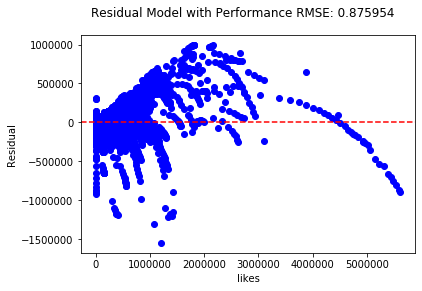

In [0]:
lr_Pred = pipelineModel_lr.transform(df_base4)
lr_Result = lr_Pred.toPandas()
resi = lr_Result.likes - lr_Result.prediction

plt.plot(lr_Result.likes, resi, 'bo')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('likes')
plt.ylabel('Residual')
plt.suptitle("Residual Model with Performance RMSE: %f" % rmse)
plt.show()

In [0]:
trainingSummary = lr_model.summary

print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5, 0.3764165126630049, 0.1689596966474839, 0.10527317935122917, 0.08306265464484451, 0.0709688282624978, 0.0633779753146018, 0.05830905551072595, 0.055817718800493826, 0.05580216957605656, 0.05579574192465669]
/databricks/spark/python/pyspark/sql/context.py:119: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 DeprecationWarning)
+-------------------+
 residuals|
+-------------------+
 -28734.16370375268|
-11098.782490561716|
-11577.131720950827|
-11738.182426889427|
-11837.888012119569|
 22245.603257745504|
 13.209665060043335|
-2705.4792823363096|
-3734.5617886940017|
 -3937.578583609313|
 -4241.079925989732|
 -4365.995399757288|
 -4507.554974306375|
 -4635.486420959234|
 25047.01841012668|
 25588.009986836463|
 25676.00610834267|
 25663.617781178094|
 25600.305487185717|
 25652.651604745537|
+-------------------+
only showing top 20 rows

### Decision Tree Regression Model
###### Perform Machine Learning model on using DecisionTreeRegressor

In [0]:
from pyspark.ml.regression import DecisionTreeRegressor

# set the decisiontree regression model with maxBins=40
dt = DecisionTreeRegressor(labelCol="likes", maxBins=40)

stages = [vecAssembler, dt]
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(trainDelta)

dtModel = pipelineModel.stages[-1]
display(dtModel)

treeNode
"{""index"":31,""featureType"":""continuous"",""prediction"":null,""threshold"":2.1162152E7,""categories"":null,""feature"":6,""overflow"":false}"
"{""index"":15,""featureType"":""continuous"",""prediction"":null,""threshold"":17062.5,""categories"":null,""feature"":8,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":6902.0,""categories"":null,""feature"":8,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":817758.5,""categories"":null,""feature"":6,""overflow"":false}"
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":1288.5,""categories"":null,""feature"":8,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":5837.654536432057,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":19710.00344390067,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":3413.5,""categories"":null,""feature"":8,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":30001.505700871898,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":56607.31012838802,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"


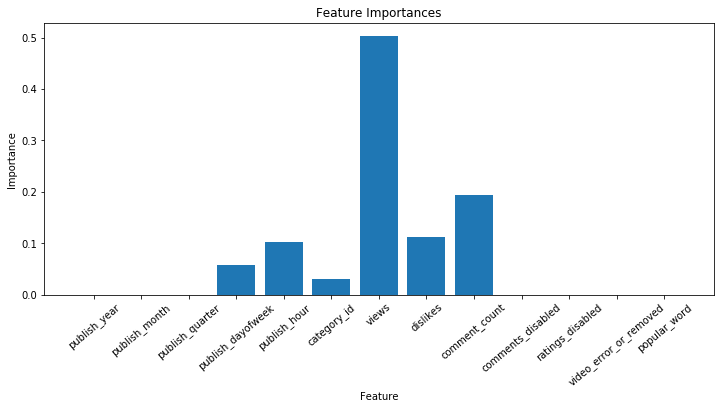

In [0]:
importances_dt = dtModel.featureImportances

x_values_dt = list(range(len(importances_dt)))

plt.figure(figsize=(12,5))
plt.bar(x_values_dt, importances_dt, orientation = 'vertical')
plt.xticks(x_values_dt, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [0]:
import pandas as pd

# condunct featureImportances to see which feature affects the result most on prediction 
dtModel.featureImportances
featuresDF_dt = pd.DataFrame(list(zip(vecAssembler.getInputCols(), dtModel.featureImportances)), columns=["feature", "importance"])
featuresDF_dt.sort_values(by=['importance'], ascending=False, inplace=True)
featuresDF_dt

,feature,importance
6,views,0.503470
8,comment_count,0.194383
7,dislikes,0.112753
4,publish_hour,0.101543
3,publish_dayofweek,0.058132
5,category_id,0.029719
0,publish_year,0.000000
1,publish_month,0.000000
2,publish_quarter,0.000000
9,comments_disabled,0.000000


In [0]:
predDF = pipelineModel.transform(testDelta)

display(predDF.select("features", "likes", "prediction").orderBy("likes", ascending=False).limit(5))

features,likes,prediction
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 1.0, 4.0, 10.0, 2.17750076E8, 335462.0, 509799.0, 0.0, 0.0, 0.0, 0.0))",4934188,4020492.3
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 6.0, 9.0, 10.0, 7.3463137E7, 156023.0, 1084421.0, 0.0, 0.0, 0.0, 0.0))",4924045,5298244.454545454
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 6.0, 9.0, 10.0, 6.5396157E7, 141966.0, 1040912.0, 0.0, 0.0, 0.0, 0.0))",4750245,5298244.454545454
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 1.0, 4.0, 10.0, 1.4242183E8, 241386.0, 414109.0, 0.0, 0.0, 0.0, 0.0))",3885070,4020492.3
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 6.0, 9.0, 10.0, 3.9349927E7, 72707.0, 692305.0, 0.0, 0.0, 0.0, 0.0))",3880071,5298244.454545454


In [0]:
regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="likes", metricName="rmse")

rmse = regressionEvaluator.evaluate(predDF)
r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")

RMSE is 92329.74533895821
R2 is 0.8280885968517626

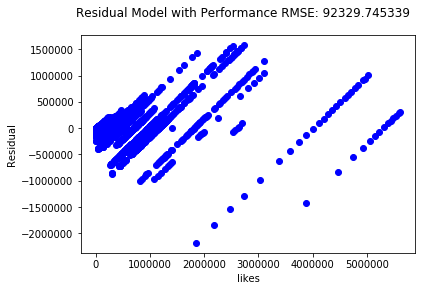

In [0]:
dt_Pred = pipelineModel.transform(df_base4)
dt_Result = dt_Pred.toPandas()
resi_dt = dt_Result.likes - dt_Result.prediction

plt.plot(dt_Result.likes, resi_dt, 'bo')
plt.xlabel('likes')
plt.ylabel('Residual')
plt.suptitle("Residual Model with Performance RMSE: %f" % rmse)
plt.show()

#### Perform Hyperparameter Tuning for DecisionTree Model

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

dt = DecisionTreeRegressor(labelCol="likes")
evaluator = RegressionEvaluator(labelCol="likes", predictionCol="prediction")

# set the paraGrid with maxDepth=[2, 5, 10], maxBins=[10, 20, 40, 80, 100]. 
paramGrid = (ParamGridBuilder()
            .addGrid(dt.maxDepth, [2, 5, 10])
            .addGrid(dt.maxBins, [10, 20, 40, 80, 100])
            .build())

# apply cross validation with numFolds=3, parallelism=4.
cv = CrossValidator(estimator=dt, evaluator=evaluator, estimatorParamMaps=paramGrid, 
                    numFolds=3, parallelism=4, seed=345)

stagesWithCV = [vecAssembler, cv]
pipeline_cv = Pipeline(stages=stagesWithCV)

# fir the model again with pipeline
pipelineModel_cv = pipeline_cv.fit(trainDelta)

predDF_cv = pipelineModel_cv.transform(testDelta)

rmse = evaluator.evaluate(predDF_cv)
r2 = evaluator.setMetricName("r2").evaluate(predDF_cv)
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
RMSE is 51573.68654842105
R2 is 0.9463613594300854

###### Display the list to find the best combination of maxDepth and maxBin after hyperparameter tuning

In [0]:
# showing the RMSE and telling which combination of maxBin and maxDepth performaces the best
best_cv = pipelineModel_cv.stages[-1]
list(zip(best_cv.getEstimatorParamMaps(), best_cv.avgMetrics))

Out[75]: [({Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
 Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 10},
 176351.81284167894),
 ({Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
 Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 20},
 159759.60481644544),
 ({Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
 Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 40},
 147068.96728513294),
 ({Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
 Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 80},
 142598.16045524494),
 ({Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
 Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 100},
 142905.81023040126),
 ({Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 10},
 157982.61935714446),
 ({Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 20},
 128858.2492383025),
 ({Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 40},
 108165.24653166175),
 ({Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 80},
 94620.10660119339),
 ({Param(parent='DecisionTreeRegressor_9550bc22d347', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2

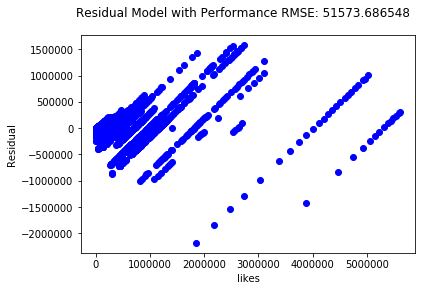

In [0]:
dt_hy_Pred = pipelineModel.transform(df_base4)
dt_hy_Result = dt_hy_Pred.toPandas()
resi_dt_cv = dt_hy_Result.likes - dt_hy_Result.prediction

plt.plot(dt_hy_Result.likes, resi_dt_cv, 'bo')
plt.xlabel('likes')
plt.ylabel('Residual')
plt.suptitle("Residual Model with Performance RMSE: %f" % rmse)
plt.show()

### Random Forest Regression Model
###### Perform RandomForrest Regression model on predicting results

In [0]:
from pyspark.ml.regression import RandomForestRegressor
import numpy as np

rf = RandomForestRegressor(labelCol="likes", featuresCol="features")

pipeline_rf = Pipeline(stages=[vecAssembler, rf])
cvModel_rf = pipeline_rf.fit(trainDelta)

predictions = cvModel_rf.transform(testDelta)
display(predictions.select("features", "likes", "prediction").orderBy("likes", ascending=False).limit(5))

features,likes,prediction
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 1.0, 4.0, 10.0, 2.17750076E8, 335462.0, 509799.0, 0.0, 0.0, 0.0, 0.0))",4934188,2902572.2525343075
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 6.0, 9.0, 10.0, 7.3463137E7, 156023.0, 1084421.0, 0.0, 0.0, 0.0, 0.0))",4924045,1768069.5843140893
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 6.0, 9.0, 10.0, 6.5396157E7, 141966.0, 1040912.0, 0.0, 0.0, 0.0, 0.0))",4750245,1768069.5843140893
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 1.0, 4.0, 10.0, 1.4242183E8, 241386.0, 414109.0, 0.0, 0.0, 0.0, 0.0))",3885070,2902572.2525343075
"List(1, 13, List(), List(2018.0, 5.0, 2.0, 6.0, 9.0, 10.0, 3.9349927E7, 72707.0, 692305.0, 0.0, 0.0, 0.0, 0.0))",3880071,1768069.5843140893


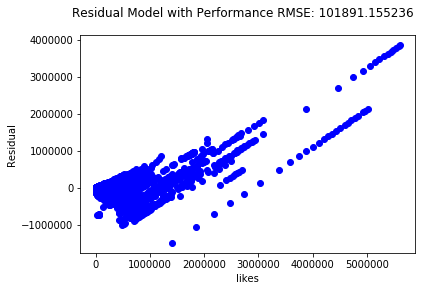

In [0]:
evaluator = RegressionEvaluator(labelCol="likes", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

rfPred = cvModel_rf.transform(df_base4)
rfResult = rfPred.toPandas()
rf_resi = rfResult.likes - rfResult.prediction

plt.plot(rfResult.likes, rf_resi, 'bo')
plt.xlabel('likes')
plt.ylabel('Residual')
plt.suptitle("Residual Model with Performance RMSE: %f" % rmse)
plt.show()

In [0]:
r2 = evaluator.setMetricName("r2").evaluate(predictions)
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")

RMSE is 101891.15523644455
R2 is 0.79063967577177

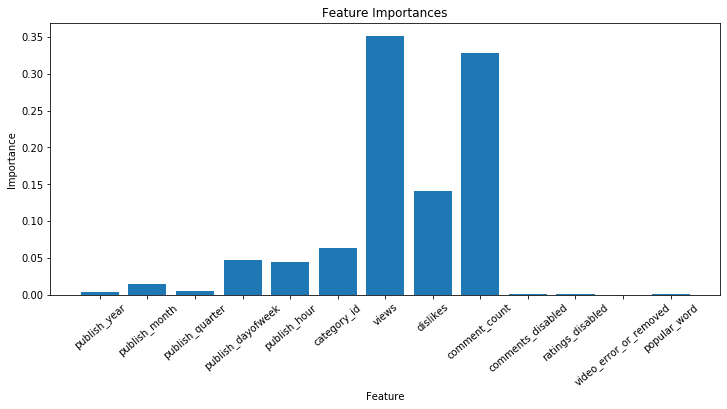

In [0]:
bestModel = cvModel_rf.stages[1]

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.figure(figsize=(12,5))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [0]:
features_rf = pd.DataFrame(list(zip(vecAssembler.getInputCols(), importances)), columns=["feature", "importance"])
features_rf.sort_values(by=['importance'], ascending=False, inplace=True)
features_rf

,feature,importance
6,views,0.351620
8,comment_count,0.327768
7,dislikes,0.140892
5,category_id,0.063606
3,publish_dayofweek,0.046731
4,publish_hour,0.044798
1,publish_month,0.014333
2,publish_quarter,0.005496
0,publish_year,0.003685
12,popular_word,0.000699


#### Perform Hyperparameter Tuning for Random Forest Model

In [0]:
rf = RandomForestRegressor(labelCol="likes", featuresCol="features")
evaluator = RegressionEvaluator(labelCol="likes", predictionCol="prediction")

# set the paraGrid with numTrees=[10, 20, 50], maxDepth=[5, 10, 15]. 
paramGrid_rf = (ParamGridBuilder()
            .addGrid(rf.numTrees, [10, 20, 50])
            .addGrid(rf.maxDepth, [5, 10, 15])
            .build())

# apply cross validation with numFolds=2, parallelism=2.
cv_rf = CrossValidator(estimator=rf, evaluator=evaluator, estimatorParamMaps=paramGrid_rf, 
                    numFolds=2, parallelism=2, seed=345)

stagesWithCV_rf = [vecAssembler, cv_rf]
pipeline_cvrf = Pipeline(stages=stagesWithCV_rf)

# fir the model again with pipeline
pipelineModel_cvrf = pipeline_cvrf.fit(trainDelta)

predDF_cvrf = pipelineModel_cvrf.transform(testDelta)

rmse = evaluator.evaluate(predDF_cvrf)
r2 = evaluator.setMetricName("r2").evaluate(predDF_cvrf)
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
RMSE is 46695.23675105105
R2 is 0.9560289766693215

In [0]:
# showing the RMSE and telling which combination of numTrees and maxDepth performaces the best
best_cvrf = pipelineModel_cvrf.stages[-1]
list(zip(best_cvrf.getEstimatorParamMaps(), best_cvrf.avgMetrics))

Out[83]: [({Param(parent='RandomForestRegressor_00f6eca67e0c', name='numTrees', doc='Number of trees to train (>= 1).'): 10,
 Param(parent='RandomForestRegressor_00f6eca67e0c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5},
 86667.96645489526),
 ({Param(parent='RandomForestRegressor_00f6eca67e0c', name='numTrees', doc='Number of trees to train (>= 1).'): 10,
 Param(parent='RandomForestRegressor_00f6eca67e0c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10},
 57907.486354068235),
 ({Param(parent='RandomForestRegressor_00f6eca67e0c', name='numTrees', doc='Number of trees to train (>= 1).'): 10,
 Param(parent='RandomForestRegressor_00f6eca67e0c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15},
 52037.242523499655),
 ({Param(parent='RandomForestRegressor_00f6eca67e0c', name='numTrees', doc='Number of trees to train (>= 1).'): 20,
 Param(parent='RandomForestRegressor_00f6eca67e0c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5},
 84796.00605169519),
 ({Param(parent='RandomForestRegressor_00f6eca67e0c', name='numTrees', doc='Number of trees to train (>= 1).'): 20,
 Param(parent='RandomForestRegressor_00f6eca67e0c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10},
 58226.280970082196),
 ({Param(parent='RandomForestRegressor_00f6eca67e0c', name='numTrees', doc='Number of trees to train (>= 1).'): 20,
 Param(parent='RandomForestRegressor_00f6eca67e0c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15},
 51738.408402885354),
 ({Param(parent='RandomForestRegressor_00f6eca67e0c', name='numTrees', doc='Number of trees to train (>= 1).'): 50,
 Param(parent='RandomForestRegressor_00f6eca67e0c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5},
 86653.18574058381),
 ({Param(parent='RandomForestRegressor_00f6eca67e0c', name='numTrees', doc='Number of trees to train (>= 1).'): 50,
 Param(parent='RandomForestRegressor_00f6eca67e0c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10},
 56960.745983543806),
 ({Param(parent='RandomForestRegressor_00f6eca67e0c', name='numTrees', doc='Number of trees to train (>= 1).'): 50,
 Param(parent='RandomForestRegressor_00f6eca67e0c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15},
 49623.358850616205)]

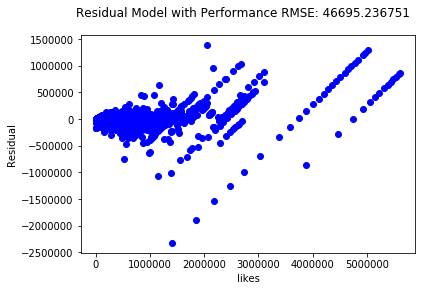

In [0]:
rf_hy_Pred = pipelineModel_cvrf.transform(df_base4)
rf_hy_Result = rf_hy_Pred.toPandas()
resi_rf_cv = rf_hy_Result.likes - rf_hy_Result.prediction

plt.plot(rf_hy_Result.likes, resi_rf_cv, 'bo')
plt.xlabel('likes')
plt.ylabel('Residual')
plt.suptitle("Residual Model with Performance RMSE: %f" % rmse)
plt.show()

###### As we can see from the result, the Random Forest Regression model after hyperparameter tuning performaces better than Decision Tree Regression model with a higher R2.